This is a follow-along notebook of [Workflows in LlamaIndex](https://colab.research.google.com/github/huggingface/agents-course/blob/main/notebooks/unit2/llama-index/workflows.ipynb) from [Hugging Face Agents Course](https://huggingface.co/learn/agents-course/unit2/llama-index/workflows), with additional trials. 

# Workflows in LlamaIndex
A workflow in LlamaIndex provides a structured way to organize your code into sequential and manageable steps.

Such a workflow is created by defining `Steps` which are triggered by `Events`, and themselves emit `Events` to trigger further steps.

Workflows offer several key benefits:

-   Clear organization of code into discrete steps
-   Event-driven architecture for flexible control flow
-   Type-safe communication between steps
-   Built-in state management
-   Support for both simple and complex agent interactions

As you might have guessed, workflows strike a great balance between the autonomy of agents while maintaining control over the overall workflow.

## Install Dependencies

In [1]:
!pip install llama-index llama-index-vector-stores-chroma llama-index-utils-workflow llama-index-llms-huggingface-api pyvis -Uqq

## Basic Workflow Creation
We can start by creating a simple workflow. We use the `StartEvent` and `StopEvent` classes to define the start and stop of the workflow.

In [2]:
from llama_index.core.workflow import StartEvent, StopEvent, Workflow, step

In [13]:
# Create `Workflow` class
class MyWorkflow(Workflow): 
    @step
    async def my_step(self, ev: StartEvent) -> StopEvent: 
        return StopEvent(result="Hello, world!")

In [4]:
# Run workflow
w = MyWorkflow(timeout=10, verbose=False)
result = await w.run()
result

'Hello, world!'

In [14]:
w = MyWorkflow(timeout=10, verbose=True)
result = await w.run()
result

Running step my_step
Step my_step produced event StopEvent


'Hello, world!'

## Connect Multiple Steps
We can also create multi-step workflows. Here we **pass the event information between steps**. Note that we can use type hinting to specify the *event type* and the *flow of the workflow*.

In [10]:
from llama_index.core.workflow import Event

In [11]:
# Class for processing event
class ProcessingEvent(Event): 
    intermediate_result: str

In [12]:
# Class for multi-step workflow
class MultiStepSWorkflow(Workflow): 
    @step
    async def step_one(self, ev: StartEvent) -> ProcessingEvent: 
        # Process initial data
        return ProcessingEvent(intermediate_result="Step 1 complete")
    
    @step
    async def step_two(self, ev: ProcessingEvent) -> StopEvent: 
        # Use the intermediate result
        final_result = f"Finished processing: {ev.intermediate_result}"
        return StopEvent(result=final_result)

In [16]:
# Run workflow
w = MultiStepSWorkflow(timeout=10, verbose=True)
result = await w.run()
result

Running step step_one
Step step_one produced event ProcessingEvent
Running step step_two
Step step_two produced event StopEvent


'Finished processing: Step 1 complete'

## Loops and Branches
We can also use type hinting to create branches and loops. Note that we can use the `|` operator to specify that the step can return *multiple types*.

In [17]:
from llama_index.core.workflow import Event
import random

In [18]:
# Class for processing event
class ProcessingEvent(Event): 
    intermediate_result: str

In [19]:
# Class for loop event
class LoopEvent(Event): 
    loop_output: str

In [33]:
# Class for multi-step workflow
class MultiStepSWorkflow(Workflow): 
    @step
    async def step_one(self, ev: StartEvent) -> ProcessingEvent | LoopEvent: 
        if random.randint(0, 1) == 0: 
            print("Bad thing happened!")
            return LoopEvent(loop_output="Back to step one.")
        else: 
            print("Good thing happened!")
            return ProcessingEvent(intermediate_result="First step complete.")
        
    @step
    async def step_two(self, ev: ProcessingEvent | LoopEvent) -> StopEvent: 
        # Use the intermediate result
        final_result = f"Finished processing: {ev.intermediate_result}"
        return StopEvent(result=final_result)

In [34]:
# Run workflow
w = MultiStepSWorkflow(verbose=True)
result = await w.run()
result

Running step step_one
Good thing happened!
Step step_one produced event ProcessingEvent
Running step step_two
Step step_two produced event StopEvent


'Finished processing: First step complete.'

In [22]:
w = MultiStepSWorkflow(verbose=True)
result = await w.run()
result

Running step step_one
Bad thing happened!
Step step_one produced event LoopEvent
Running step step_two


WorkflowRuntimeError: Error in step 'step_two': 'LoopEvent' object has no attribute 'intermediate_result'

In [27]:
class MultiStepSWorkflow(Workflow): 
    @step
    async def step_one(self, ev: StartEvent) -> ProcessingEvent | LoopEvent: 
        if random.randint(0, 1) == 0: 
            print("Bad thing happened!")
            return LoopEvent(loop_output="Back to step one.")
        else: 
            print("Good thing happened!")
            return ProcessingEvent(intermediate_result="First step complete.")
        
    @step
    async def step_two(self, ev: ProcessingEvent | LoopEvent) -> StopEvent: 
        # Use the intermediate result        
        output = ev.intermediate_result if hasattr(ev, "intermediate_result") and ev.intermediate_result is not None else ev.loop_output        
        final_result = f"Finished processing: {output}"
        return StopEvent(result=final_result)

In [28]:
w = MultiStepSWorkflow(verbose=True)
result = await w.run()
result

Running step step_one
Bad thing happened!
Step step_one produced event LoopEvent
Running step step_two
Step step_two produced event StopEvent


'Finished processing: Back to step one.'

In [30]:
w = MultiStepSWorkflow(verbose=True)
result = await w.run()
result

Running step step_one
Good thing happened!
Step step_one produced event ProcessingEvent
Running step step_two
Step step_two produced event StopEvent


'Finished processing: First step complete.'

## Drawing Workflows
We can also draw workflows using the `draw_all_possible_flows` function.

In [31]:
from llama_index.utils.workflow import draw_all_possible_flows

In [35]:
draw_all_possible_flows(w)

workflow_all_flows.html


In [37]:
w = MultiStepSWorkflow(verbose=True)
result = await w.run()
result

Running step step_one
Bad thing happened!
Step step_one produced event LoopEvent
Running step step_two


WorkflowRuntimeError: Error in step 'step_two': 'LoopEvent' object has no attribute 'intermediate_result'

In [38]:
class MultiStepSWorkflow(Workflow): 
    @step
    async def step_one(self, ev: StartEvent | LoopEvent) -> ProcessingEvent | LoopEvent: 
        if random.randint(0, 1) == 0: 
            print("Bad thing happened!")
            return LoopEvent(loop_output="Back to step one.")
        else: 
            print("Good thing happened!")
            return ProcessingEvent(intermediate_result="First step complete.")
        
    @step
    async def step_two(self, ev: ProcessingEvent) -> StopEvent: 
        # Use the intermediate result
        final_result = f"Finished processing: {ev.intermediate_result}"
        return StopEvent(result=final_result)

In [39]:
w = MultiStepSWorkflow(verbose=True)
result = await w.run()
result

Running step step_one
Bad thing happened!
Step step_one produced event LoopEvent
Running step step_one
Bad thing happened!
Step step_one produced event LoopEvent
Running step step_one
Good thing happened!
Step step_one produced event ProcessingEvent
Running step step_two
Step step_two produced event StopEvent


'Finished processing: First step complete.'

In [40]:
draw_all_possible_flows(w)

workflow_all_flows.html


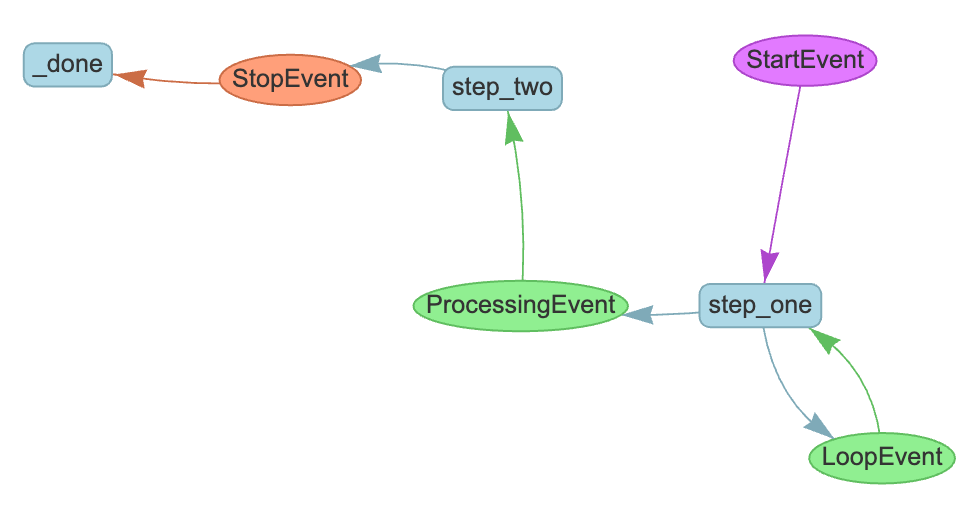

## State Management
Instead of passing the event information between steps, we can use the `Context` type hint to pass information between steps. 
This might be useful for long running workflows, where you want to store information between steps.

In [ ]:
from llama_index.core.workflow import Event, Context

In [50]:
class ProcessingEvent(Event): 
    intermediate_result: str

In [51]:
class MultiStepSWorkflow(Workflow): 
    @step
    async def step_one(self, ev: StartEvent, ctx: Context) -> ProcessingEvent: 
        # Process initial data
        await ctx.set("query", "What is the capital of France?")
        return ProcessingEvent(intermediate_result="Step 1 complete")
    
    @step
    async def step_two(self, ev: ProcessingEvent, ctx: Context) -> StopEvent: 
        # Use the intermediate result
        query = await ctx.get("query")
        print(f"Query: {query}")
        final_result = f"Finished processing: {ev.intermediate_result}"
        return StopEvent(result=final_result)

In [52]:
w = MultiStepSWorkflow(timeout=10, verbose=True)
result = await w.run()
result

Running step step_one
Step step_one produced event ProcessingEvent
Running step step_two
Query: What is the capital of France?
Step step_two produced event StopEvent


'Finished processing: Step 1 complete'

In [56]:
w.is_done()

True

In [60]:
w.stream_events()

<async_generator object Workflow.stream_events at 0x1102f6980>

In [62]:
w._timeout

10

## Multi-Agent Workflows

In [75]:
from llama_index.llms.ollama import Ollama
from llama_index.core.agent.workflow import ReActAgent, AgentWorkflow
# `FunctionAgent` works for LLMs with a function calling API. 
# `ReActAgent` works for any LLMs. 

In [76]:
# Define some tools
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [77]:
# Initialize model
llm = Ollama(model="qwen3:8b", request_timeout=600.0)

In [78]:
# Initialize agents
agent_multiply = ReActAgent(
    name="agent_multiply", 
    description="Is able to multiply two integers",
    system_prompt="A helpful assistant that can use a tool to multiply numbers.",
    tools=[multiply], 
    llm=llm
)

agent_add = ReActAgent(
    name="agent_add", 
    description="Is able to add two integers",
    system_prompt="A helpful assistant that can use a tool to add numbers.",
    tools=[add], 
    llm=llm
)

In [79]:
# Create workflow
workflow = AgentWorkflow(
    agents=[agent_multiply, agent_add], 
    root_agent="agent_multiply"
)

In [81]:
# Run the system
response = await workflow.run(user_msg="Can you add 5 and 3?")
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='The sum of 5 and 3 is 8.')]), tool_calls=[ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_add', 'reason': 'The user is asking to add two integers, which is the expertise of agent_add.'}, tool_id='228bd261-9da8-4f71-af16-6a7eb67b9444', tool_output=ToolOutput(content='Agent agent_add is now handling the request due to the following reason: The user is asking to add two integers, which is the expertise of agent_add..\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'agent_add', 'reason': 'The user is asking to add two integers, which is the expertise of agent_add.'}}, raw_output='Agent agent_add is now handling the request due to the following reason: The user is asking to add two integers, which is the expertise of agent_add..\nPlease continue with the

In [82]:
print(response)

The sum of 5 and 3 is 8.


In [83]:
# Run the system
response = await workflow.run(user_msg="Add 8 and 2 then multiply the output by 2")
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='The sum of 8 and 2 is 10. Multiplying 10 by 2 gives 20. The final answer is 20.')]), tool_calls=[ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_add', 'reason': 'Performing addition of 8 and 2'}, tool_id='7c5d3b7d-9989-43c7-9f4b-e7767b3e6576', tool_output=ToolOutput(content='Agent agent_add is now handling the request due to the following reason: Performing addition of 8 and 2.\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'agent_add', 'reason': 'Performing addition of 8 and 2'}}, raw_output='Agent agent_add is now handling the request due to the following reason: Performing addition of 8 and 2.\nPlease continue with the current request.', is_error=False), return_direct=True)], raw={'model': 'qwen3:8b', 'created_at': '2025-05-20T08:40:44.858078Z',

In [84]:
print(response)

The sum of 8 and 2 is 10. Multiplying 10 by 2 gives 20. The final answer is 20.


In [87]:
response.tool_calls

[ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_add', 'reason': 'Performing addition of 8 and 2'}, tool_id='7c5d3b7d-9989-43c7-9f4b-e7767b3e6576', tool_output=ToolOutput(content='Agent agent_add is now handling the request due to the following reason: Performing addition of 8 and 2.\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'agent_add', 'reason': 'Performing addition of 8 and 2'}}, raw_output='Agent agent_add is now handling the request due to the following reason: Performing addition of 8 and 2.\nPlease continue with the current request.', is_error=False), return_direct=True)]


In [90]:
response.model_config

{'arbitrary_types_allowed': True}

In [92]:
response.response

ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='The sum of 8 and 2 is 10. Multiplying 10 by 2 gives 20. The final answer is 20.')])

## Modify Workflow State
Before starting the workflow, we can provide an <u>initial state dict</u> that will be available to *all agents*. The state is stored in the *state key of the workflow context*. It will be injected into the `state_prompt` which augments each new user message.

Let’s inject a counter to count function calls by modifying the previous example:

In [99]:
from llama_index.core.agent.workflow import AgentWorkflow
from llama_index.core.workflow import Context

In [ ]:
# Define some tools
async def add(ctx: Context, a: int, b: int) -> int: 
    "Add two numbers."
    # Update the count
    current_state = await ctx.get("state")
    current_state = "1"

    await ctx.set(key="state", value=current_state)

    return a + b

async def multiply(ctx: Context, a: int, b: int) -> int: 
    "Multiply two numbers."
    # Update the count
    current_state = await ctx.get("state")
    current_state["num_fn_calls"] += 1
    await ctx.set("state", current_state)

    return a * b

In [162]:
# Create workflow
workflow = AgentWorkflow(
    agents=[agent_add, agent_multiply], 
    root_agent="agent_multiply", 
    initial_state={"num_fn_calls": "0"}, 
    state_prompt="Current state: {state}. User message: {msg}"
)

In [157]:
# Run workflow with `Context`
ctx = Context(workflow)
response = await workflow.run(user_msg="Cau you add 5 and 3?", ctx=ctx)
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='The sum of 5 and 3 is 8.\n```')]), tool_calls=[ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_add', 'reason': 'The user wants to add 5 and 3'}, tool_id='ab1062c5-ce9e-4d1c-b0ce-9a0b227c6491', tool_output=ToolOutput(content='Agent agent_add is now handling the request due to the following reason: The user wants to add 5 and 3.\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'agent_add', 'reason': 'The user wants to add 5 and 3'}}, raw_output='Agent agent_add is now handling the request due to the following reason: The user wants to add 5 and 3.\nPlease continue with the current request.', is_error=False), return_direct=True)], raw={'model': 'qwen3:8b', 'created_at': '2025-05-20T10:20:11.637422Z', 'done': True, 'done_reason': 'stop', 'total_duration'

In [158]:
print(response)

The sum of 5 and 3 is 8.
```


In [159]:
# Inspect state
state = await ctx.get("state")
state

{'num_fn_calls': '0'}

In [160]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': \'0\'}. User message: Cau you add 5 and 3?"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: The current language of the question is English. The user is asking to add two numbers, which is a task suited for the agent_add. I should hand off the task to agent_add.\\nAction: handoff\\nAction Input: {\'to_agent\': \'agent_add\', \'reason\': \'The user wants to add 5 and 3\'}\\nObservation: Agent agent_add is now handling the request due to the following reason: The user wants to add 5 and 3.\\nPlease continue with the current request.\\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: The sum of 5 and 3 is 8.\\n```"}]}]}, "class_name": "SimpleChatStore"}, "chat_store

```python
'state': '{"num_fn_calls": 0}',
```

`'{"num_fn_calls": 0}'` becomes string type. 

In [113]:
workflow.state_prompt

PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['state', 'msg'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='Current state: {state}. User message: {msg}')

In [114]:
print(workflow.state_prompt)

metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>} template_vars=['state', 'msg'] kwargs={} output_parser=None template_var_mappings=None function_mappings=None template='Current state: {state}. User message: {msg}'


In [119]:
# Define some tools
async def add(ctx: Context, a: int, b: int) -> int: 
    "Add two numbers."
    # Update the count
    current_state = await ctx.get("state")
    current_state["num_fn_calls"] += 1
    print("tool_add :", current_state["num_fn_calls"])
    await ctx.set("state", current_state)

    return a + b

async def multiply(ctx: Context, a: int, b: int) -> int: 
    "Multiply two numbers."
    # Update the count
    current_state = await ctx.get("state")
    current_state["num_fn_calls"] += 1
    print("tool_multiply :", current_state["num_fn_calls"])
    await ctx.set("state", current_state)

    return a * b

In [116]:
# Run workflow with `Context`
ctx = Context(workflow)
response = await workflow.run(user_msg="Cau you add 5 and 3?", ctx=ctx)
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text="5 + 3 equals 8.\n</think>\n\nThought: I can answer without using any more tools. I'll use the user's language to answer\nAnswer: 5 + 3 equals 8.")]), tool_calls=[ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_add', 'reason': 'Can you add 5 and 3?'}, tool_id='45768242-6b0a-48ed-a5a1-be8cc8c8bc88', tool_output=ToolOutput(content='Agent agent_add is now handling the request due to the following reason: Can you add 5 and 3?.\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'agent_add', 'reason': 'Can you add 5 and 3?'}}, raw_output='Agent agent_add is now handling the request due to the following reason: Can you add 5 and 3?.\nPlease continue with the current request.', is_error=False), return_direct=True), ToolCallResult(tool_name='add', tool_kwargs={'

In [117]:
print(response)

5 + 3 equals 8.
</think>

Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: 5 + 3 equals 8.


In [118]:
state = await ctx.get("state")
state["num_fn_calls"]

0

In [120]:
# Run workflow with `Context`
ctx = Context(workflow)
response = await workflow.run(user_msg="You must use tools to add 8 and 2 then multiply the output by 2", ctx=ctx)
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='The result of adding 8 and 2 is 10. Multiplying this by 2 gives 20.')]), tool_calls=[ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_add', 'reason': 'Add 8 and 2'}, tool_id='577a52c3-9e61-4764-9bcf-2ee3939d4088', tool_output=ToolOutput(content='Agent agent_add is now handling the request due to the following reason: Add 8 and 2.\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'agent_add', 'reason': 'Add 8 and 2'}}, raw_output='Agent agent_add is now handling the request due to the following reason: Add 8 and 2.\nPlease continue with the current request.', is_error=False), return_direct=True), ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'agent_multiply', 'reason': 'Multiply the result of 8+2 by 2'}, tool_id='301b8faf-b0cd-49c2-b832-b

In [121]:
print(response)

The result of adding 8 and 2 is 10. Multiplying this by 2 gives 20.


In [122]:
state = await ctx.get("state")
state["num_fn_calls"]

0

In [164]:
from llama_index.core.workflow import Context, JsonSerializer

async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers and update the state."""
    cur_state = await ctx.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)
    return a * b

# Define the workflow
workflow = AgentWorkflow(
    agents=[agent_multiply],
    root_agent="agent_multiply",
    initial_state={"num_fn_calls": 0},
    state_prompt="Current state: {state}. User message: {msg}",
)

# Initialize context
ctx = Context(workflow)

# Run the workflow and serialize the context state
await workflow.run(user_msg="Multiply 2 and 3", ctx=ctx)
ctx_dict = ctx.to_dict(serializer=JsonSerializer())

# Restore the context state and run the workflow again
restored_ctx = Context.from_dict(workflow, ctx_dict, serializer=JsonSerializer())
await workflow.run(user_msg="Multiply 4 and 5", ctx=restored_ctx)

# Check the updated state
state = await restored_ctx.get("state")
print(state["num_fn_calls"])  # Should print 2

0


In [209]:
from llama_index.core.workflow import Context, JsonSerializer

async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers and update the state."""
    ctx_dict = ctx.to_dict(serializer=JsonSerializer())
    cur_state = await ctx_dict["globals"]["state"]
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)
    return a * b

# Define the workflow
workflow = AgentWorkflow(
    agents=[agent_multiply],
    root_agent="agent_multiply",
    initial_state={"num_fn_calls": 0},
    state_prompt="Current state: {state}. User message: {msg}",
)

# Initialize context
ctx = Context(workflow)

# Run the workflow and serialize the context state
response = await workflow.run(user_msg="Multiply 2 and 3", ctx=ctx)
ctx_dict = ctx.to_dict(serializer=JsonSerializer())

# Restore the context state and run the workflow again
restored_ctx = Context.from_dict(workflow, ctx_dict, serializer=JsonSerializer())
response = await workflow.run(user_msg="Multiply 4 and 5", ctx=restored_ctx)

# Check the updated state
state = await restored_ctx.get("state")
print(state["num_fn_calls"])  # Should print 2

0


In [210]:
print(response)

The product of 4 and 5 is 20.


In [211]:
response

AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='The product of 4 and 5 is 20.')]), tool_calls=[ToolCallResult(tool_name='multiply', tool_kwargs={'a': 4, 'b': 5}, tool_id='100f6772-e3a5-448c-b7c2-23e8c32dab03', tool_output=ToolOutput(content='20', tool_name='multiply', raw_input={'args': (), 'kwargs': {'a': 4, 'b': 5}}, raw_output=20, is_error=False), return_direct=False)], raw={'model': 'qwen3:8b', 'created_at': '2025-05-20T11:02:00.437351Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7758867667, 'load_duration': 14471375, 'prompt_eval_count': 722, 'prompt_eval_duration': 299483125, 'eval_count': 163, 'eval_duration': 7422720041, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'usage': {'prompt_tokens': 722, 'completion_tokens': 163, 'total_tokens': 885}}, current_agent_name='agent_multiply')

In [172]:
from llama_index.core.workflow import Context, JsonSerializer

In [174]:
ctx = Context(workflow)
response = await workflow.run(user_msg="Hi, my name is Laurie!", ctx=ctx)
print(response)

Hello, Laurie! It's a pleasure to meet you. How can I assist you today?


In [175]:
response2 = await workflow.run(user_msg="What's my name?", ctx=ctx)
print(response2)

Your name is Laurie!


In [176]:
ctx_dict = ctx.to_dict(serializer=JsonSerializer())
restored_ctx = Context.from_dict(
    workflow, ctx_dict, serializer=JsonSerializer()
)

response3 = await workflow.run(user_msg="What's my name?", ctx=restored_ctx)
response3


AgentOutput(response=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, additional_kwargs={'tool_calls': []}, blocks=[TextBlock(block_type='text', text='Your name is Laurie!')]), tool_calls=[], raw={'model': 'qwen3:8b', 'created_at': '2025-05-20T10:43:45.954343Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7666954917, 'load_duration': 14258792, 'prompt_eval_count': 639, 'prompt_eval_duration': 282887375, 'eval_count': 167, 'eval_duration': 7357867791, 'message': Message(role='assistant', content='', images=None, tool_calls=None), 'usage': {'prompt_tokens': 639, 'completion_tokens': 167, 'total_tokens': 806}}, current_agent_name='agent_multiply')

In [177]:
print(response3)

Your name is Laurie!


In [178]:
ctx_dict

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: Hi, my name is Laurie!"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: Hello, Laurie! It\'s a pleasure to meet you. How can I assist you today?"}]}, {"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: What\'s my name?"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: Your name is Laurie!"}]}]}, "class_name": "SimpleChatStore"}, "chat_store_key": "chat_history", "token_limit": 

In [195]:
type(ctx_dict)

dict

In [206]:
ctx_dict

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: Hi, my name is Laurie!"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: Hello, Laurie! It\'s a pleasure to meet you. How can I assist you today?"}]}, {"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: What\'s my name?"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: Your name is Laurie!"}]}]}, "class_name": "SimpleChatStore"}, "chat_store_key": "chat_history", "token_limit": 

In [205]:
ctx_dict.keys()

dict_keys(['globals', 'streaming_queue', 'queues', 'stepwise', 'event_buffers', 'in_progress', 'accepted_events', 'broker_log', 'is_running'])

In [207]:
ctx_dict["globals"]

{'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: Hi, my name is Laurie!"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: Hello, Laurie! It\'s a pleasure to meet you. How can I assist you today?"}]}, {"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: What\'s my name?"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: Your name is Laurie!"}]}]}, "class_name": "SimpleChatStore"}, "chat_store_key": "chat_history", "token_limit": 2925, "class

In [208]:
ctx_dict["globals"]["state"]

'{"num_fn_calls": 0}'

In [ ]:
async def set_name(ctx: Context, name: str) -> str:
    state = await ctx.get("state")
    state["name"] = name
    await ctx.set("state", state)
    return f"Name set to {name}"

In [ ]:
workflow = AgentWorkflow.from_tools_or_functions(
    [set_name],
    llm=llm,
    system_prompt="You are a helpful assistant that can set a name.",
    initial_state={"name": "unset"},
)

In [181]:
ctx = Context(workflow)

# check if it knows a name before setting it
response = await workflow.run(user_msg="What's my name?", ctx=ctx)
print(str(response))

<think>
Okay, the user is asking, "What's my name?" Let me check the current state. The state shows that the name is 'unset'. So, I need to inform them that their name hasn't been set yet. But wait, there's a function called set_name that can be used to set the name. Maybe I should prompt them to provide their name so I can use that function. Let me make sure I'm not missing anything. The function requires a 'name' parameter, which is a string. Since the current name is unset, I should ask the user to specify their name. Then I can call set_name with their provided name. Alright, I'll respond by asking for their name.
</think>

Your name is currently unset. Could you please provide your name so I can set it for you?


In [183]:
response2 = await workflow.run(user_msg="My name is Laurie", ctx=ctx)
print(response2)

<think>
Okay, the user said their name is Laurie, so I need to call the set_name function with "Laurie" as the argument. Let me check the function signature again to make sure. The function requires a "name" parameter of type string. Since the user provided their name, I'll format the tool call correctly. Once the function is called, the name should be set, and I should confirm it back to the user. Alright, everything looks good. Let's send the tool call.
</think>

Your name has been set to Laurie. Is there anything else I can assist you with?


In [184]:
state = await ctx.get("state")
print("Name as stored in state: ", state["name"])

Name as stored in state:  Laurie


In [185]:
state

{'name': 'Laurie'}

In [188]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state:\\n{\'name\': \'unset\'}\\n\\nCurrent message:\\nWhat\'s my name?\\n"}]}, {"role": "assistant", "additional_kwargs": {"tool_calls": []}, "blocks": [{"block_type": "text", "text": "<think>\\nOkay, the user is asking, \\"What\'s my name?\\" Let me check the current state. The state shows that the name is \'unset\'. So, I need to inform them that their name hasn\'t been set yet. But wait, there\'s a function called set_name that can be used to set the name. Maybe I should prompt them to provide their name so I can use that function. Let me make sure I\'m not missing anything. The function requires a \'name\' parameter, which is a string. Since the current name is unset, I should ask the user to specify their name. Then I can call set_name with their provided name. Alright, I\'ll respond by as

In [189]:
multiply_agent = ReActAgent(
    name="multiply_agent",
    description="Is able to multiply two integers",
    system_prompt="A helpful assistant that can use a tool to multiply numbers.",
    tools=[multiply], 
    llm=llm,
)

addition_agent = ReActAgent(
    name="add_agent",
    description="Is able to add two integers",
    system_prompt="A helpful assistant that can use a tool to add numbers.",
    tools=[add], 
    llm=llm,
)

In [192]:
from llama_index.core.agent.workflow import AgentWorkflow
from llama_index.core.workflow import Context, JsonSerializer

In [ ]:
# Define some tools
async def add(ctx: Context, a: int, b: int) -> int:
    """Add two numbers."""
    # update our count
    ctx_dict = ctx.to_dict(serializer=JsonSerializer())
    cur_state = await ctx_dict["globals"]["state"]
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)

    return a + b

async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers."""
    # update our count
    ctx_dict = ctx.to_dict(serializer=JsonSerializer())
    cur_state = await ctx_dict["globals"]["state"]
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)

    return a * b

In [194]:
workflow = AgentWorkflow(
    agents=[multiply_agent, addition_agent],
    root_agent="multiply_agent", 
    initial_state={"num_fn_calls": 0},
)

# run the workflow with context
ctx = Context(workflow)
response = await workflow.run(user_msg="Can you add 5 and 3?", ctx=ctx)

# pull out and inspect the state
state = await ctx.get("state")
print(state["num_fn_calls"])

0


In [213]:
async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers."""
    # update our count
    cur_state = await ctx.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)

    return a * b

In [214]:
workflow = AgentWorkflow.from_tools_or_functions(
    [multiply],
    llm=llm,
    system_prompt="You are a helpful assistant that can multiply two numbers and set number of function calls.",
    initial_state={"num_fn_calls": 0},
)

In [215]:
ctx = Context(workflow)

# check if it knows a name before setting it
response = await workflow.run(user_msg="Multiply 3 and 8, then multiply the result by 2", ctx=ctx)
print(response)

<think>
Okay, let's see. The user asked to multiply 3 and 8 first. So I called the multiply function with 3 and 8, which gave 24. Then they wanted to multiply that result by 2. So I used the multiply function again with 24 and 2, which gave 48. Both steps were necessary because the user specified to first multiply 3 and 8, then take that result and multiply by 2. I made sure to use the correct order and parameters for each function call. The final answer should be 48.
</think>

The result of multiplying 3 and 8 is 24. Then, multiplying 24 by 2 gives the final result of **48**.


In [216]:
state = await ctx.get("state")
print(state["num_fn_calls"])

2


In [218]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state:\\n{\'num_fn_calls\': 0}\\n\\nCurrent message:\\nMultiply 3 and 8, then multiply the result by 2\\n"}]}, {"role": "assistant", "additional_kwargs": {"tool_calls": [{"function": {"name": "multiply", "arguments": {"a": 3, "b": 8}}}, {"function": {"name": "multiply", "arguments": {"a": 24, "b": 2}}}]}, "blocks": [{"block_type": "text", "text": ""}]}, {"role": "tool", "additional_kwargs": {"tool_call_id": "multiply"}, "blocks": [{"block_type": "text", "text": "24"}]}, {"role": "tool", "additional_kwargs": {"tool_call_id": "multiply"}, "blocks": [{"block_type": "text", "text": "48"}]}, {"role": "assistant", "additional_kwargs": {"tool_calls": []}, "blocks": [{"block_type": "text", "text": "<think>\\nOkay, let\'s see. The user asked to multiply 3 and 8 first. So I called the multiply function wi

In [232]:
workflow = AgentWorkflow(
    agents=[agent_multiply],
    root_agent="agent_multiply",
    initial_state={"num_fn_calls": 0},
    state_prompt="You are a helpful assistant that can set number of function calls. Current state: {state}. User message: {msg}",        
)

In [233]:
ctx = Context(workflow)

# check if it knows a name before setting it
response = await workflow.run(user_msg="Multiply 3 and 8, then multiply the result by 2", ctx=ctx)
print(response)

48


In [234]:
state = await ctx.get("state")
print(state["num_fn_calls"])

0


In [235]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "You are a helpful assistant that can set number of function calls. Current state: {\'num_fn_calls\': 0}. User message: Multiply 3 and 8, then multiply the result by 2"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 3, \'b\': 8}\\nObservation: 24\\nThought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 24, \'b\': 2}\\nObservation: 48\\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: 48"}]}]}, "class_name": "SimpleChatStore"}, "chat_store_key": "chat_history", "t

In [228]:
ctx_dict = ctx.to_dict()
ctx_dict["globals"]["num_tool_calls"]

'1'

In [237]:
from llama_index.core.workflow import Context, JsonSerializer

async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers and update the state."""
    cur_state = await ctx.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)
    return a * b

# Define the workflow
workflow = AgentWorkflow(
    agents=[multiply_agent],
    root_agent="multiply_agent",
    initial_state={"num_fn_calls": 0},
    state_prompt="Current state: {state}. User message: {msg}",
)

# Initialize context
ctx = Context(workflow)

# Run the workflow and serialize the context state
await workflow.run(user_msg="Multiply 2 and 3", ctx=ctx)
ctx_dict = ctx.to_dict(serializer=JsonSerializer())

# Restore the context state and run the workflow again
restored_ctx = Context.from_dict(workflow, ctx_dict, serializer=JsonSerializer())
await workflow.run(user_msg="Multiply 4 and 5", ctx=restored_ctx)

# Check the updated state
state = await restored_ctx.get("state")
print(state["num_fn_calls"])  # Should print 2

2


In [239]:
restored_ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: Multiply 2 and 3"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 2, \'b\': 3}\\nObservation: 6\\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: The product of 2 and 3 is 6.\\n</think>\\n\\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: The product of 2 and 3 is 6."}]}, {"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 1}. User message: Multiply 4 and 5"}]}, {"role": "assistant", "

In [240]:
# Run the workflow and serialize the context state
await workflow.run(user_msg="Multiply 2 and 3", ctx=ctx)
ctx_dict = ctx.to_dict(serializer=JsonSerializer())

# Restore the context state and run the workflow again
restored_ctx = Context.from_dict(workflow, ctx_dict, serializer=JsonSerializer())
await workflow.run(user_msg="Multiply 4 and 5", ctx=restored_ctx)

restored_ctx = Context.from_dict(workflow, ctx_dict, serializer=JsonSerializer())
await workflow.run(user_msg="Multiply 3 and 4", ctx=restored_ctx)

# Check the updated state
state = await restored_ctx.get("state")
print(state["num_fn_calls"])

3


In [244]:
# Initialize context
ctx = Context(workflow)

# Run the workflow and serialize the context state
await workflow.run(user_msg="Multiply 3 and 8, then multiply the result by 2", ctx=ctx)
ctx_dict = ctx.to_dict(serializer=JsonSerializer())

# Check the updated state
state = await ctx.get("state")
print(state["num_fn_calls"])

6


In [245]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 4}. User message: Multiply 3 and 8, then multiply the result by 2"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 3, \'b\': 8}\\nObservation: 24\\nThought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 24, \'b\': 2}\\nObservation: 48\\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: The result of multiplying 3 and 8, then multiplying the result by 2, is 48."}]}]}, "class_name": "SimpleChatStore"}, "chat_store_key": "chat_histor

## Complete Workflow

In [1]:
from llama_index.llms.ollama import Ollama
from llama_index.core.agent.workflow import ReActAgent, AgentWorkflow
from llama_index.core.workflow import Context

In [2]:
# Define some tools
async def add(ctx: Context, a: int, b: int) -> int:
    """Add two numbers."""
    # update our count
    cur_state = await ctx.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)

    return a + b

async def multiply(ctx: Context, a: int, b: int) -> int:
    """Multiply two numbers."""
    # update our count
    cur_state = await ctx.get("state")
    cur_state["num_fn_calls"] += 1
    await ctx.set("state", cur_state)

    return a * b

In [3]:
# Initialize model
llm = Ollama(model="qwen3:8b", request_timeout=600.0)

In [4]:
# Initialize agents
multiply_agent = ReActAgent(
    name="multiply_agent",
    description="Is able to multiply two integers",
    system_prompt="A helpful assistant that can use a tool to multiply numbers.",
    tools=[multiply],
    llm=llm,
)

addition_agent = ReActAgent(
    name="add_agent",
    description="Is able to add two integers",
    system_prompt="A helpful assistant that can use a tool to add numbers.",
    tools=[add],
    llm=llm,
)

In [5]:
# Create workflow
workflow = AgentWorkflow(
    agents=[multiply_agent, addition_agent],
    root_agent="multiply_agent",
    initial_state={"num_fn_calls": 0},
    state_prompt="Current state: {state}. User message: {msg}",
)

In [12]:
# Initialize context
ctx = Context(workflow)

# Run the workflow
response = await workflow.run(user_msg="Multiply 3 and 8, then multiply the result by 2", ctx=ctx)
print("===RESPONSE===")
print(response)
print()

# Check the updated state
state = await ctx.get("state")
print("===num_fn_calls===")
print(state["num_fn_calls"])

===RESPONSE===
The result of multiplying 3 and 8, then multiplying the result by 2, is 48.

===num_fn_calls===
4


In [13]:
response.tool_calls

[ToolCallResult(tool_name='multiply', tool_kwargs={'a': 3, 'b': 8}, tool_id='d1f55606-62b9-453d-9086-8b3e0e3fad51', tool_output=ToolOutput(content='24', tool_name='multiply', raw_input={'args': (), 'kwargs': {'a': 3, 'b': 8}}, raw_output=24, is_error=False), return_direct=False),
 ToolCallResult(tool_name='multiply', tool_kwargs={'a': 24, 'b': 2}, tool_id='67ac68f9-9a1f-494c-b90c-1f9e84a111d2', tool_output=ToolOutput(content='48', tool_name='multiply', raw_input={'args': (), 'kwargs': {'a': 24, 'b': 2}}, raw_output=48, is_error=False), return_direct=False)]

In [7]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: Multiply 3 and 8, then multiply the result by 2"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 3, \'b\': 8}\\nObservation: 24\\nThought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 24, \'b\': 2}\\nObservation: 48\\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\\nAnswer: 48"}]}]}, "class_name": "SimpleChatStore"}, "chat_store_key": "chat_history", "token_limit": 2925, "class_name": "ChatMemoryBuffer"}, "qualified_na

In [9]:
# Create workflow
workflow = AgentWorkflow(
    agents=[multiply_agent, addition_agent],
    root_agent="multiply_agent",
    initial_state={"num_fn_calls": 0},
    state_prompt="Current state: {state}. User message: {msg}",
)

# Initialize context
ctx = Context(workflow)

# Run the workflow
response = await workflow.run(user_msg="Multiply 3 and 8, then add by 5431834", ctx=ctx)
print("===RESPONSE===")
print(response)
print()

# Check the updated state
state = await ctx.get("state")
print("===num_fn_calls===")
print(state["num_fn_calls"])

===RESPONSE===
The result of multiplying 3 and 8, then adding 5431834, is 5431858.

===num_fn_calls===
2


In [10]:
ctx.to_dict()

{'globals': {'memory': '{"__is_component": true, "value": {"chat_store": {"store": {"chat_history": [{"role": "user", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Current state: {\'num_fn_calls\': 0}. User message: Multiply 3 and 8, then add by 5431834"}]}, {"role": "assistant", "additional_kwargs": {}, "blocks": [{"block_type": "text", "text": "Thought: The current language of the user is: English. I need to use a tool to help me answer the question.\\nAction: multiply\\nAction Input: {\'a\': 3, \'b\': 8}\\nObservation: 24\\nThought: I need to add the result of the multiplication (24) with 5431834. Since there\'s an add_agent available, I should hand off the task to them.\\nAction: handoff\\nAction Input: {\'to_agent\': \'add_agent\', \'reason\': \'Need to add 24 and 5431834\'}\\nObservation: Agent add_agent is now handling the request due to the following reason: Need to add 24 and 5431834.\\nPlease continue with the current request.\\nThought: The current lang

In [11]:
response.tool_calls

[ToolCallResult(tool_name='multiply', tool_kwargs={'a': 3, 'b': 8}, tool_id='65329d43-ff20-4e80-8a38-0bb0da354dd1', tool_output=ToolOutput(content='24', tool_name='multiply', raw_input={'args': (), 'kwargs': {'a': 3, 'b': 8}}, raw_output=24, is_error=False), return_direct=False),
 ToolCallResult(tool_name='handoff', tool_kwargs={'to_agent': 'add_agent', 'reason': 'Need to add 24 and 5431834'}, tool_id='0407c6db-23d4-46f0-aad2-b7d25c01a6ee', tool_output=ToolOutput(content='Agent add_agent is now handling the request due to the following reason: Need to add 24 and 5431834.\nPlease continue with the current request.', tool_name='handoff', raw_input={'args': (), 'kwargs': {'to_agent': 'add_agent', 'reason': 'Need to add 24 and 5431834'}}, raw_output='Agent add_agent is now handling the request due to the following reason: Need to add 24 and 5431834.\nPlease continue with the current request.', is_error=False), return_direct=True),
 ToolCallResult(tool_name='add', tool_kwargs={'a': 24, 'b':

## References
[Maintaining state - LlamaIndex](https://docs.llamaindex.ai/en/stable/understanding/agent/state/)